In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torch
import numpy as np
import pandas as pd

import altair as alt

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle

from reportlab.lib.utils import ImageReader
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter

from cuml.manifold.umap import UMAP

import base64
import io
from io import BytesIO
from PIL import Image

from src.clusters import HierarchicalCluster
from src import (
  hierarchical_kmeans_gpu as hkmg,
  hierarchical_sampling as hs
)

In [26]:
#features = np.load("/home/tcecconello/radioimgs/radio-data-curation-ssl/features/features.npy")
features = np.load("/home/tcecconello/radioimgs/radio-data-curation-ssl/features/features_clip/features.npy")
info = pd.read_json("/home/tcecconello/radioimgs/radio-data-curation-ssl/LoTSS/cutouts/info.json", orient="index")
info.head()

,file_path,source_type,survey,mosaic_name,position,size
0,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 3968]",256
1,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4096]",256
2,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4224]",256
3,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4352]",256
4,/home/tcecconello/radioimgs/radio-data-curatio...,UNKNOWN,LoTTS,P334+36,"[128, 4480]",256


<b/> Add neighbors information

In [ ]:


# Simuliamo il dataframe con le colonne che hai indicato
"""
data = {
    "file_path": ["/path/to/file"] * 7,
    "source_type": ["UNKNOWN"] * 7,
    "survey": ["LoTTS"] * 7,
    "mosaic_name": ["P334+36"] * 7,
    "position": [[128, 3968], [128, 4096], [128, 4224], [128, 4352], [128, 4480], [384, 4096], [384, 4352]],
    "size": [256] * 7,
}
df = pd.DataFrame(data)
"""

def find_neighbors(df):
    # Creiamo due colonne per memorizzare gli indici dei vicini
    df["4_neighbors"] = [[] for _ in range(len(df))]
    df["8_neighbors"] = [[] for _ in range(len(df))]
    
    # Raggruppiamo per mosaico
    grouped = df.groupby("mosaic_name")
    
    for _, group in grouped:
        index_map = {tuple(pos): idx for idx, pos in zip(group.index, group["position"])}
        
        for idx, pos in zip(group.index, group["position"]):
            x, y = pos
            
            # 4 vicini (orizzontali e verticali)
            four_neighbors = []
            if (x, y + 128) in index_map:
                four_neighbors.append(index_map[(x, y + 128)])
            if (x, y - 128) in index_map:
                four_neighbors.append(index_map[(x, y - 128)])
            if (x + 256, y) in index_map:
                four_neighbors.append(index_map[(x + 256, y)])
            if (x - 256, y) in index_map:
                four_neighbors.append(index_map[(x - 256, y)])
            
            # 8 vicini (diagonali)
            eight_neighbors = []
            if (x + 256, y + 128) in index_map:
                eight_neighbors.append(index_map[(x + 256, y + 128)])
            if (x + 256, y - 128) in index_map:
                eight_neighbors.append(index_map[(x + 256, y - 128)])
            if (x - 256, y + 128) in index_map:
                eight_neighbors.append(index_map[(x - 256, y + 128)])
            if (x - 256, y - 128) in index_map:
                eight_neighbors.append(index_map[(x - 256, y - 128)])
            
            df.at[idx, "4_neighbors"] = four_neighbors
            df.at[idx, "8_neighbors"] = eight_neighbors
    
    return df

# Applichiamo la funzione
info = find_neighbors(info)
print(info)


In [4]:
cl = HierarchicalCluster.from_file("/home/tcecconello/radioimgs/radio-data-curation-ssl/data/try_3_clip")
sampled_indices = hs.hierarchical_sampling(cl, target_size=200000)
print("Numerosità media dei cluster per livello \n Livello 1:{} \n Livello 2:{} \n Livello 3:{}".format(np.mean(cl.clusters_size[1]), np.mean(cl.clusters_size[2]), np.mean(cl.clusters_size[3])))
print("Numerosità massima dei cluster per livello \n Livello 1:{} \n Livello 2:{} \n Livello 3:{}".format(np.max(cl.clusters_size[1]), np.max(cl.clusters_size[2]), np.max(cl.clusters_size[3])))

Hierarchical sampling from clusters: 100%|██████████| 3000/3000 [00:01<00:00, 2161.44it/s]
Numerosità media dei cluster per livello 
 Livello 1:31.08232 
 Livello 2:10.0 
 Livello 3:3.3333333333333335
Numerosità massima dei cluster per livello 
 Livello 1:2477742 
 Livello 2:61 
 Livello 3:20


In [5]:
def get_item_clusters(flat_clusters, clusters, item):
    """
    Traccia l'appartenenza di un elemento (`item`) attraverso i livelli
    e restituisce gli indici e gli elementi dei cluster.

    Args:
        flat_clusters (dict): Cluster appiattiti per ogni livello.
        clusters (dict): Cluster non appiattiti per ogni livello.
        item (int): L'elemento da tracciare.

    Returns:
        dict: Dizionario con i livelli come chiavi e tuple (indice_cluster, elementi_cluster).
    """
    result = {}  # Per memorizzare indici e cluster di ciascun livello

    # Livello 1: Trova direttamente l'elemento
    for i, cluster in enumerate(flat_clusters[1]):
        if item in cluster:
            result[1] = (i, cluster)  # Salva indice e cluster
            break
    else:
        raise ValueError(f"Item {item} non trovato in livello 1")

    # Livelli successivi: Risali i livelli e raccogli cluster
    current_cluster_index = result[1][0]  # Indice del cluster a livello 1
    for level in range(2, len(flat_clusters) + 1):
        for i, cluster in enumerate(clusters[level]):
            if current_cluster_index in cluster:
                # Salva indice e cluster appiattito
                result[level] = (i, flat_clusters[level][i])
                current_cluster_index = i  # Aggiorna per il livello successivo
                break
        else:
            raise ValueError(f"Item {item} non trovato in livello {level}")

    return result


In [6]:
def plot_clusters(df, clusters_info, sampled_indices, n_cols=5, max_images=25):
    """
    Visualizza fino a un massimo di `max_images` immagini per cluster con bordi colorati.

    Args:
        df (pd.DataFrame): DataFrame contenente i path delle immagini (colonna "file_path").
        clusters_info (dict): Dizionario con i cluster di ciascun livello.
                              Formato: {livello: (indice_cluster, elementi_cluster)}.
        sampled_indices (list): Lista di indici con bordo verde (gli altri avranno bordo rosso).
        n_cols (int): Numero di colonne nel plot.
        max_images (int): Numero massimo di immagini da visualizzare per livello.
    """
    for level, (cluster_index, cluster_elements) in clusters_info.items():
        print(f"Plotting cluster {cluster_index} at level {level} with {len(cluster_elements)} images...")

        # Limita il numero di immagini da visualizzare
        cluster_elements = cluster_elements[:max_images]
        n_images = len(cluster_elements)
        n_rows = (n_images + n_cols - 1) // n_cols  # Calcola il numero di righe necessarie

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
        axs = axs.flatten()  # Per iterare facilmente sugli assi

        for i, ax in enumerate(axs):
            if i < n_images:
                image_index = cluster_elements[i]

                # Ottieni il file_path
                file_path = df.loc[image_index, "file_path"]
                if not os.path.exists(file_path):
                    print(f"File non trovato: {file_path}")
                    ax.axis('off')
                    continue

                # Carica l'immagine come array numpy
                image = np.load(file_path)
                image = np.log1p(image * 200)

                # Visualizza l'immagine
                ax.imshow(image, cmap='gray')
                ax.axis('off')

                # Aggiungi il bordo colorato
                border_color = "#80ef80" if image_index in sampled_indices else "red"
                rect = Rectangle((0, 0), image.shape[1], image.shape[0],
                                 linewidth=5, edgecolor=border_color, facecolor='none')
                ax.add_patch(rect)
            else:
                # Disattiva gli assi vuoti
                ax.axis('off')

        plt.suptitle(f"Cluster {cluster_index} - Livello {level}", fontsize=16)
        plt.tight_layout()
        plt.show()


Livello 1:
  Indice del cluster: 98236
  Elementi del cluster: [1846038]
Livello 2:
  Indice del cluster: 2030
  Elementi del cluster: [2264787 2791843  157328 2549277 2628432 1613640  271639 2293852  561237
 2359878  671058  739565 1846038 2252831  271638 2839772 1161987  466064
 2419023 2550418  274970]
Livello 3:
  Indice del cluster: 1
  Elementi del cluster: [2935931  373531  716399  912944  505958 1896852  223835 1289332  462376
 1596694 1185055 3022799 1487678  211315 2795006 1472438  942993 2609899
  210826 1185054 1958372 2324300 2465983 2774816 1081091 2012233 1156410
 2264787 2791843  157328 2549277 2628432 1613640  271639 2293852  561237
 2359878  671058  739565 1846038 2252831  271638 2839772 1161987  466064
 2419023 2550418  274970  426163 1752061  467669  483720 2751122 1893604
 1729636   22135 2054391 1448902  810488  608662 1390002  162533 2836814
  414363 1427129  572950  338580 1881029 2994577 1525411 2107129 1129108
 1734727  563757 2609788 1036453 2231351 1703317  

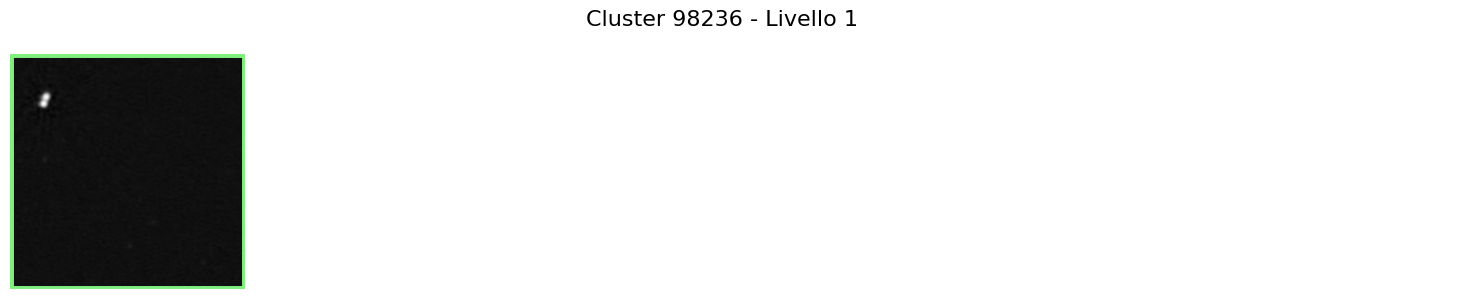

Plotting cluster 2030 at level 2 with 21 images...


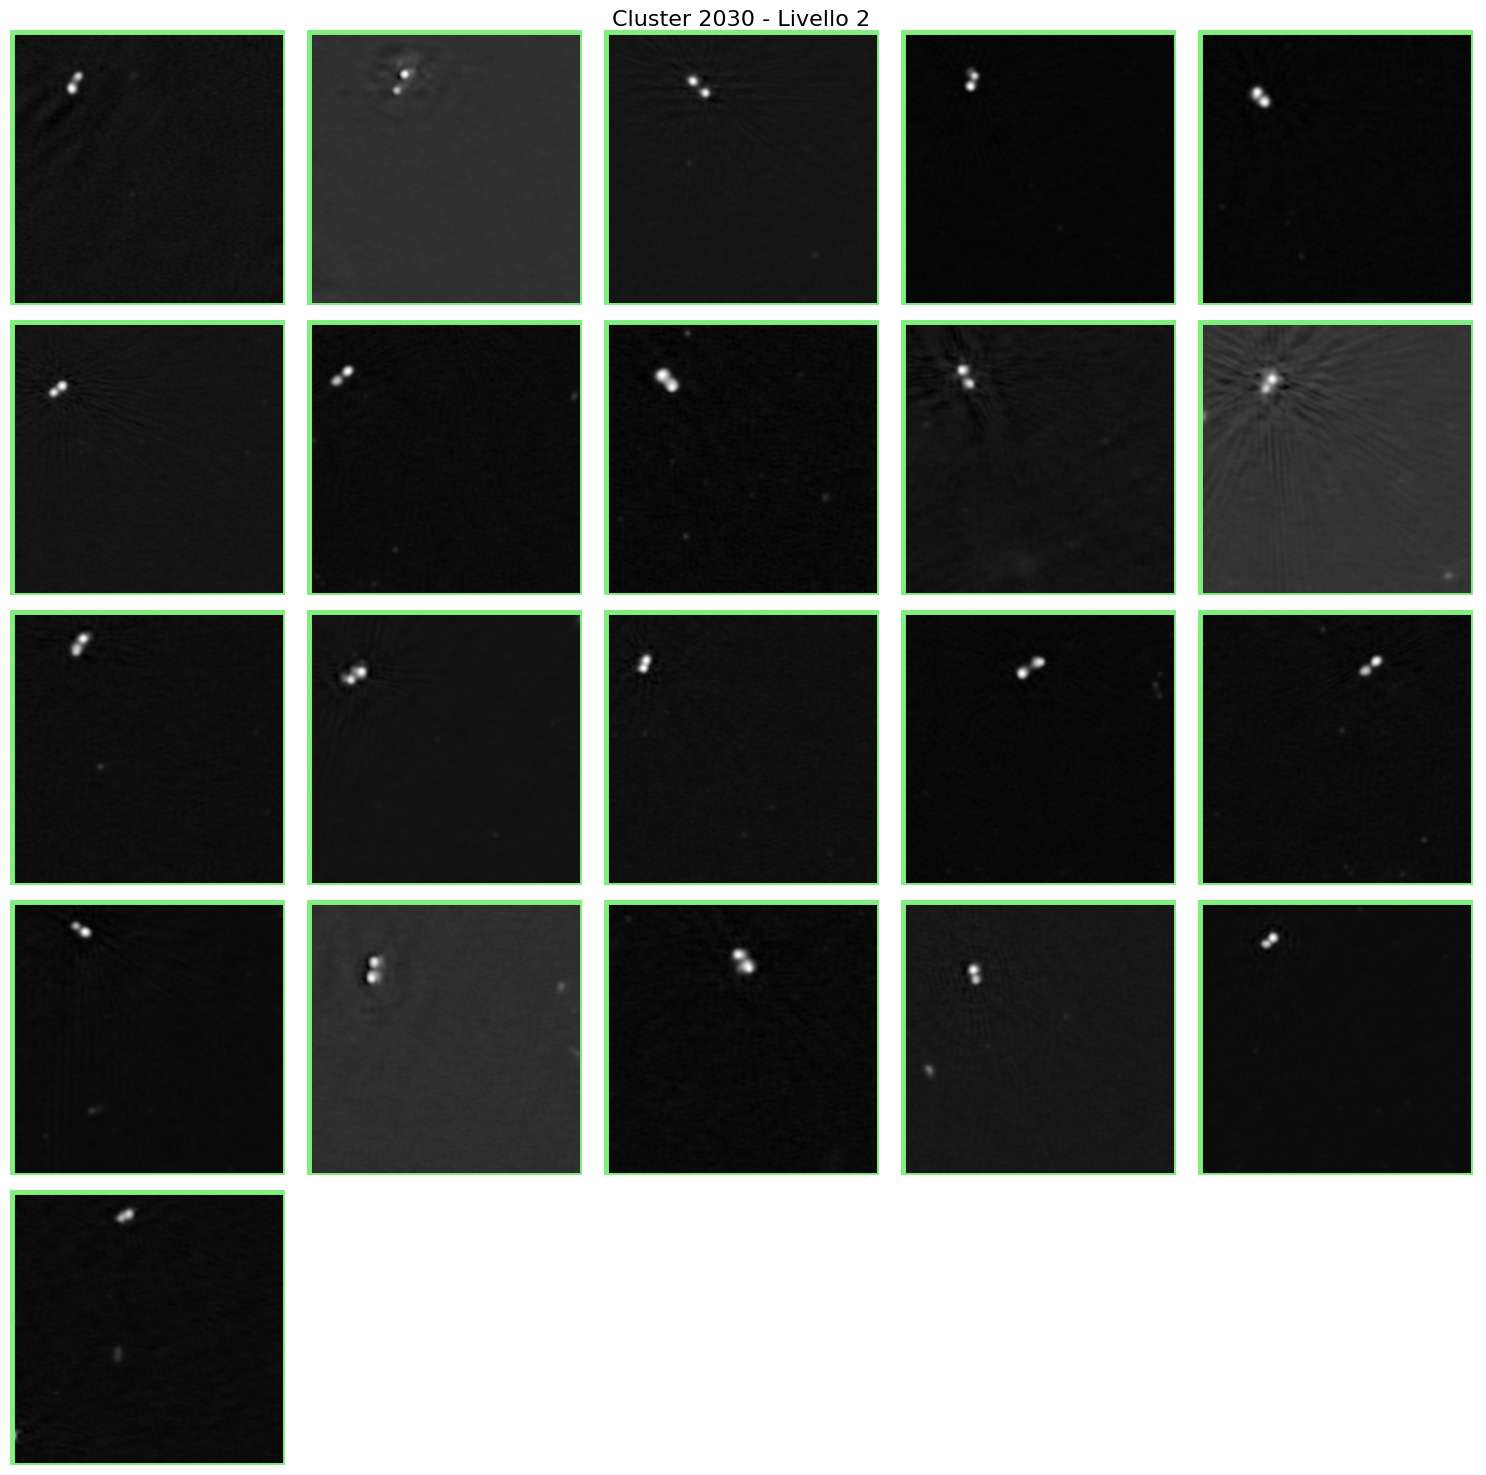

Plotting cluster 1 at level 3 with 297 images...


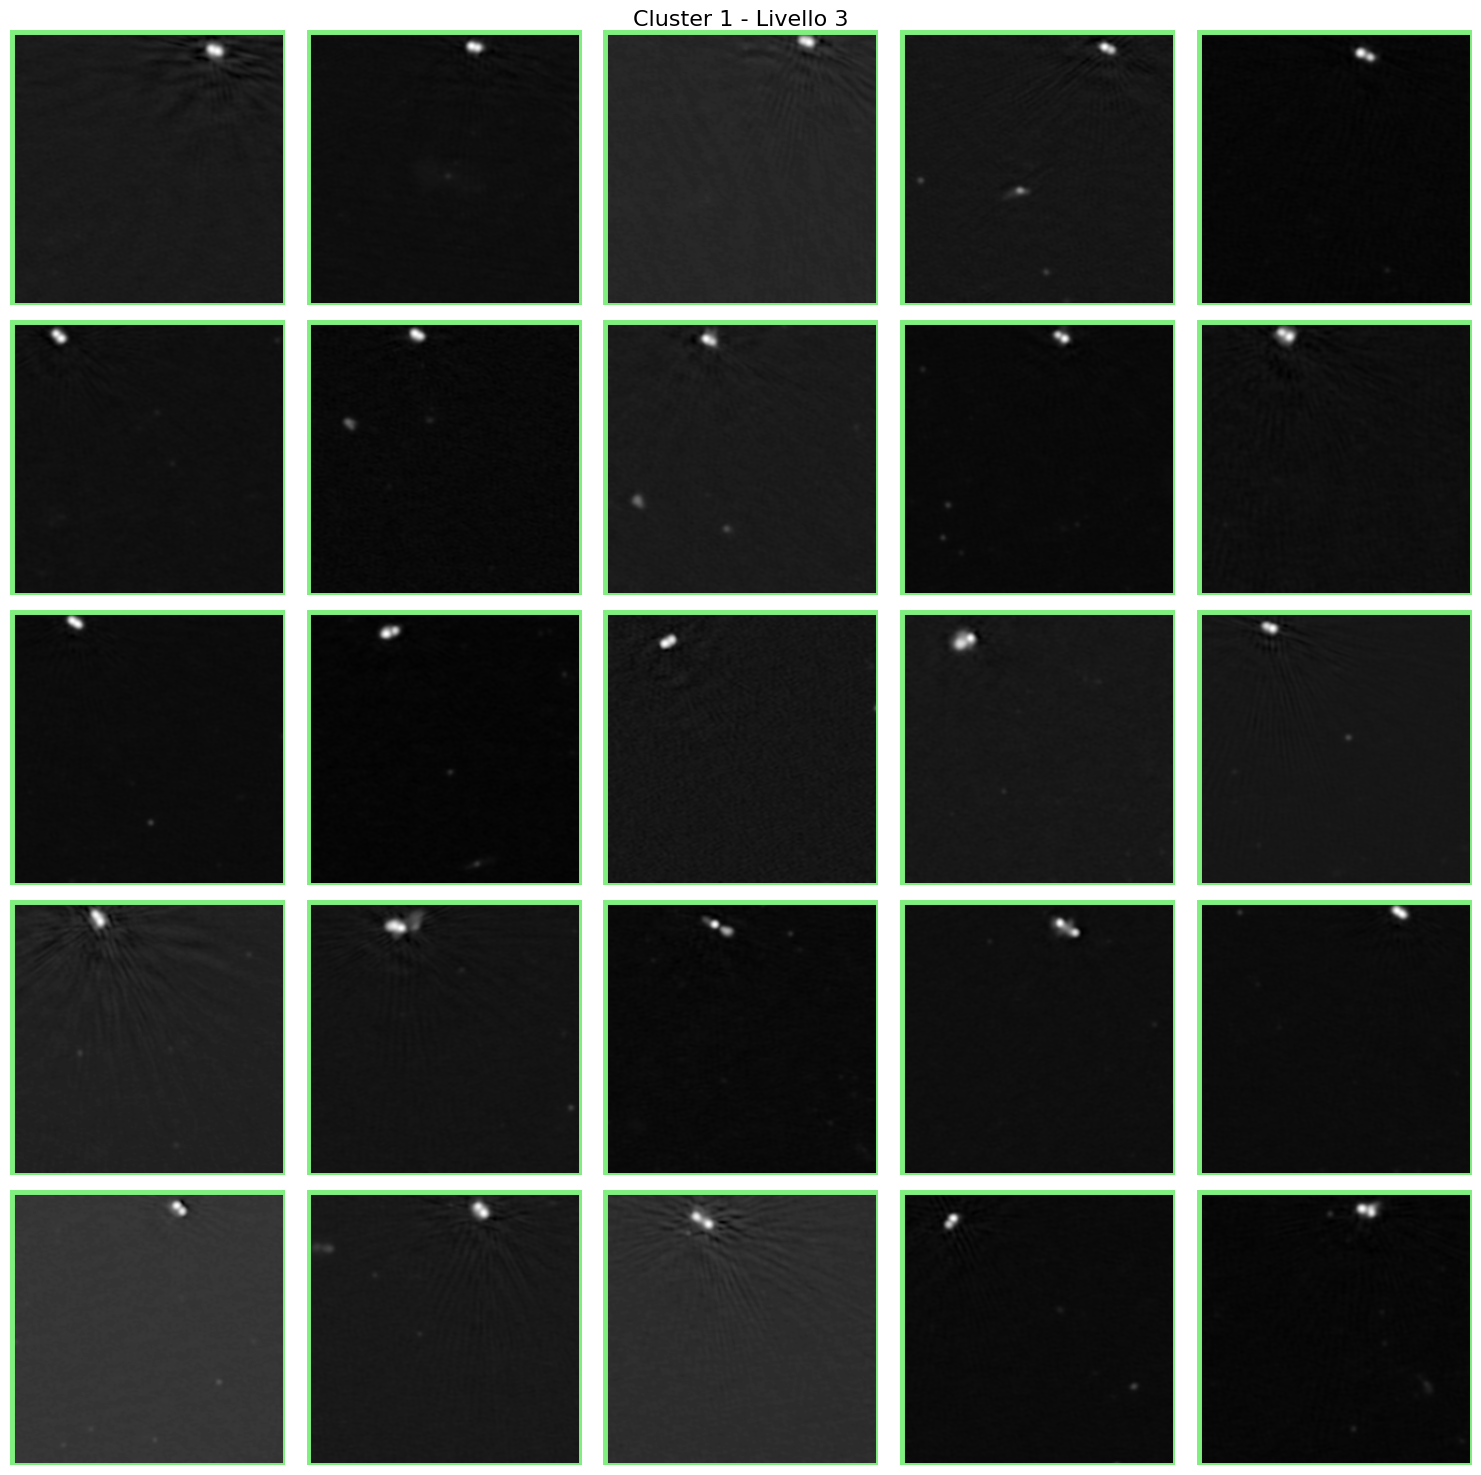

In [24]:
item = 1846038 #sampled_indices[100]  # Elemento da tracciare
clusters_info = get_item_clusters(cl.flat_clusters, cl.clusters, item)

# Visualizza gli indici e gli elementi dei cluster
for level, (cluster_index, cluster_elements) in clusters_info.items():
    print(f"Livello {level}:")
    print(f"  Indice del cluster: {cluster_index}")
    print(f"  Elementi del cluster: {cluster_elements}")

# Indici con bordo verde
#sampled_indices = [sampled_indices[3], sampled_indices[2]]

# Visualizza i cluster
plot_clusters(info, clusters_info, sampled_indices)
